# Acoustic EDA
This notebook demonstrates some EDA of the acoustic features from some of the main datasets for SER.

In [1]:
#!pip install opensmile
#!pip install kagglehub
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")

print("Path to dataset files:", path)

files = [file_path.name for file_path in os.scandir(path+"/wav") if file_path.is_file()]

import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)

feats_df = smile.process_files([path+"/wav/"+file for file in files])



/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1


              precision    recall  f1-score   support

       anger       0.78      0.76      0.77        33
     boredom       0.71      0.67      0.69        18
     disgust       0.46      0.86      0.60         7
        fear       0.60      0.53      0.56        17
   happiness       0.44      0.47      0.45        15
     sadness       0.12      0.12      0.12         8
     neutral       1.00      0.67      0.80         9

    accuracy                           0.62       107
   macro avg       0.59      0.58      0.57       107
weighted avg       0.64      0.62      0.62       107



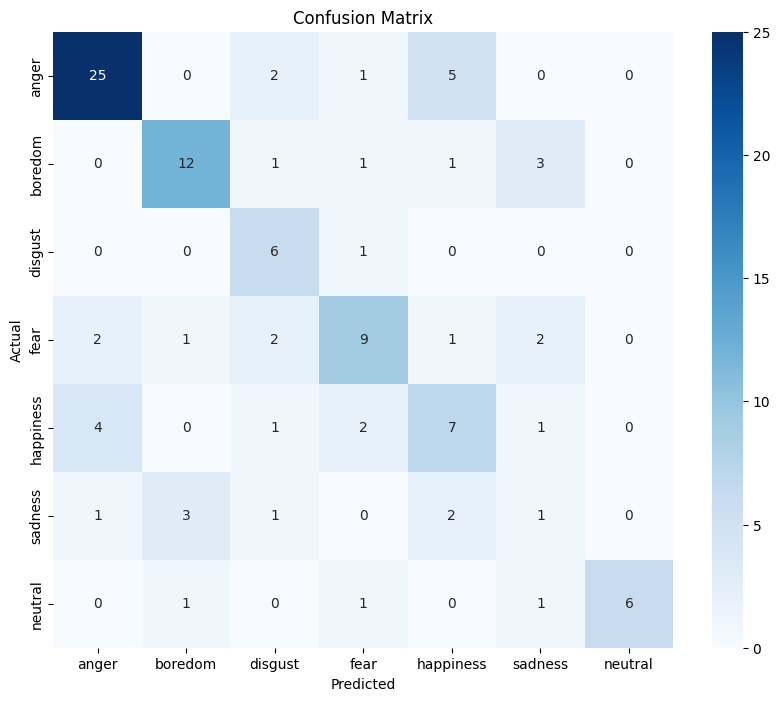

In [6]:
#test_labels = emo_db.label #iloc[:100,].label
#train_labels = emo_db.label #iloc[100:,].label
#test_feats = feats_df.iloc[:100,]
#train_feats = feats_df.iloc[100:,]
import pandas as pd
emo_db = pd.read_csv("emo_db_transcripts.csv")

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Now us only the three center formant frequencies
centerformantfreqs = ['F1frequency_sma3nz_amean', 'F2frequency_sma3nz_amean', 'F3frequency_sma3nz_amean']
#exclude_cols = 
formant_df = feats_df#[exclude_cols] #[centerformantfreqs]
formant_df.head()
# feats_df['label'] = emo_db.label
train_feats, test_feats, train_labels, test_labels = train_test_split(formant_df, emo_db.label, test_size=0.2, random_state=42)
#clf = svm.SVC()
clf = svm.SVC(kernel='linear')
clf.fit(train_feats, train_labels)
pred_labels  = clf.predict(test_feats)

emotions = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}
print(classification_report(test_labels, pred_labels, target_names=emotions.values()))

confusion_matrix(test_labels, pred_labels)
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_labels, pred_labels), annot=True, fmt='d', cmap='Blues', xticklabels=emotions.values(), yticklabels=emotions.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Selected features: 21
Train shape after selection: (428, 21)
Validation accuracy: 66.04%
Test accuracy: 70.37%
              precision    recall  f1-score   support

       anger       0.72      0.87      0.79        15
     boredom       1.00      0.57      0.73         7
     disgust       0.45      1.00      0.62         5
        fear       0.86      0.75      0.80         8
   happiness       0.67      0.40      0.50        10
     sadness       0.50      0.67      0.57         3
     neutral       1.00      0.67      0.80         6

    accuracy                           0.70        54
   macro avg       0.74      0.70      0.69        54
weighted avg       0.76      0.70      0.70        54



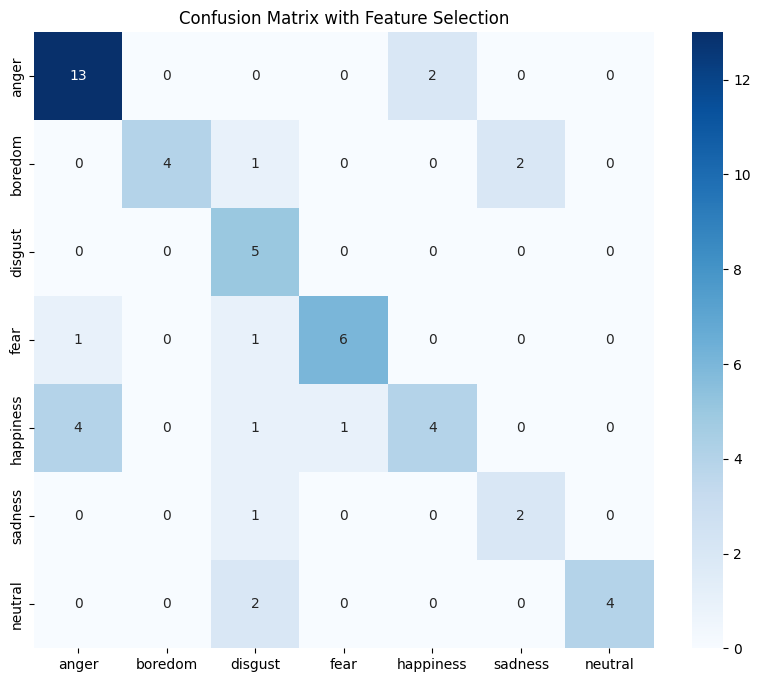

In [8]:
# Split dataset into train, val, test
from sklearn.model_selection import train_test_split
import seaborn as sns
from select_features import algorithm1, algorithm2
from sklearn.base import BaseEstimator, TransformerMixin

# Convert features and labels to numpy arrays
X = feats_df.values
y = emo_db.label.values

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 50% val, 50% test of temp (10% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Modified FeatureSelector for 1D audio features
class AudioFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='algorithm2', L=0.95, MS=0.8):
        self.selector = algorithm2 if algorithm == 'algorithm2' else algorithm1
        self.L = L
        self.MS = MS
        self.selected_indices = None
        self.algorithm = algorithm

    def fit(self, X, y=None):
        if self.algorithm == 'algorithm2':
            self.selected_indices = self.selector(X, L=self.L, MS=self.MS)
        else:
            self.selected_indices = self.selector(X, L=self.L)
        return self

    def transform(self, X):
        return X[:, self.selected_indices]

# Apply feature selection
selector = AudioFeatureSelector(algorithm='algorithm2', L=0.95, MS=0.8)
selector.fit(X_train)

# Transform all datasets
X_train_sel = selector.transform(X_train)
X_val_sel = selector.transform(X_val)
X_test_sel = selector.transform(X_test)

print("Selected features:", len(selector.selected_indices))
print("Train shape after selection:", X_train_sel.shape)

# Train and evaluate SVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create pipeline with scaling and SVM
pipeline = make_pipeline(
    StandardScaler(),
    svm.SVC(kernel='linear', random_state=42)
)

# Train on selected features
pipeline.fit(X_train_sel, y_train)

# Evaluate on validation set
val_acc = pipeline.score(X_val_sel, y_val)
print(f"Validation accuracy: {val_acc:.2%}")

# Final evaluation on test set
test_acc = pipeline.score(X_test_sel, y_test)
print(f"Test accuracy: {test_acc:.2%}")

print(classification_report(y_test, pipeline.predict(X_test_sel), target_names=emotions.values()))

# Confusion matrix with selected features
pred_labels = pipeline.predict(X_test_sel)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, pred_labels), 
            annot=True, fmt='d', 
            cmap='Blues',
            xticklabels=emotions.values(),
            yticklabels=emotions.values())
plt.title('Confusion Matrix with Feature Selection')
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import kagglehub
import os

2025-03-06 09:14:22.776829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# https://www.kaggle.com/datasets/msambare/fer2013
# Download dataset
file_path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", file_path)

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [5]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen.flow_from_directory(
    file_path+"/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="training"
)

val_data = data_gen.flow_from_directory(
    file_path+"/test",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="validation"
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


Epoch 1/10
359/359 [==============================] - 30s 80ms/step - loss: 1.7014 - accuracy: 0.3211 - val_loss: 1.5670 - val_accuracy: 0.4085
Epoch 2/10
359/359 [==============================] - 28s 78ms/step - loss: 1.5482 - accuracy: 0.4029 - val_loss: 1.4818 - val_accuracy: 0.4260
Epoch 3/10
359/359 [==============================] - 32s 89ms/step - loss: 1.4644 - accuracy: 0.4367 - val_loss: 1.4099 - val_accuracy: 0.4749
Epoch 4/10
359/359 [==============================] - 27s 75ms/step - loss: 1.4039 - accuracy: 0.4638 - val_loss: 1.3733 - val_accuracy: 0.4763
Epoch 5/10
359/359 [==============================] - 28s 78ms/step - loss: 1.3558 - accuracy: 0.4811 - val_loss: 1.3205 - val_accuracy: 0.4958
Epoch 6/10
359/359 [==============================] - 27s 76ms/step - loss: 1.3091 - accuracy: 0.5004 - val_loss: 1.2994 - val_accuracy: 0.4909
Epoch 7/10
359/359 [==============================] - 28s 77ms/step - loss: 1.2659 - accuracy: 0.5152 - val_loss: 1.2890 - val_accuracy:

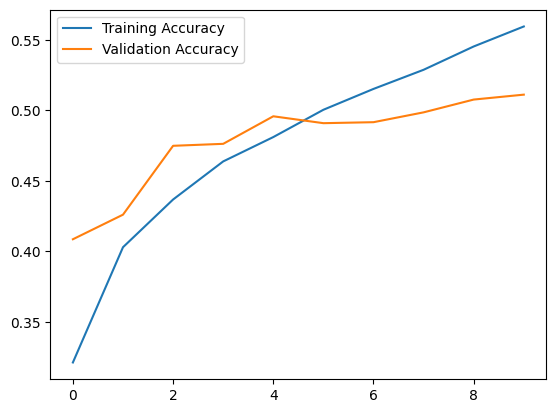

In [6]:


# After verifying number of classes matches (either 2 or 7)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # Match number of classes found by flow_from_directory
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=10)

eval_results = model.evaluate(val_data)
print(f"Validation Accuracy: {eval_results[1] * 100:.2f}%")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [13]:
from select_features import algorithm1, algorithm2
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='algorithm2', L=0.95, MS=0.8):
        self.selector = algorithm2 if algorithm == 'algorithm2' else algorithm1
        self.L = L
        self.MS = MS
        self.selected_indices = None
        self.new_shape = None
        self.algorithm = algorithm

    def fit(self, X, y=None):
        # Flatten images for feature selection
        X_flat = X.reshape(X.shape[0], -1)
        if self.algorithm == 'algorithm2':
            self.selected_indices = self.selector(X_flat, L=self.L, MS=self.MS)
        else:
            self.selected_indices = self.selector(X_flat, L=self.L)

        # Calculate nearest square dimensions
        n_features = len(self.selected_indices)
        self.new_dim = int(np.sqrt(n_features))
        if self.new_dim**2 != n_features:
            self.new_dim += 1  # Round up to next square
            self.pad_width = self.new_dim**2 - n_features
        else:
            self.pad_width = 0
            
        return self

    def transform(self, X):
        # Reshape and select features
        X_flat = X.reshape(X.shape[0], -1)
        X_selected = X_flat[:, self.selected_indices]
        
        # Pad features to make perfect square
        if self.pad_width > 0:
            X_selected = np.pad(X_selected, 
                              ((0,0), (0,self.pad_width)), 
                              mode='constant')
            
        return X_selected.reshape(-1, self.new_dim, self.new_dim, 1)

# 1. Load full dataset
def load_full_dataset(generator):
    X, y = [], []
    batches = 0
    for X_batch, y_batch in generator:
        X.append(X_batch)
        y.append(y_batch)
        batches += 1
        if batches >= len(generator):
            break
    return np.vstack(X), np.vstack(y)

# Load all data (caution: ensure it fits in memory)
X_train_full, y_train_full = load_full_dataset(train_data)
X_val_full, y_val_full = load_full_dataset(val_data)
print(f"Training data shape: {X_train_full.shape}")

# 2. Apply Feature Selection
selector = FeatureSelector(algorithm='algorithm1', L=0.85) # L=0.95)
#selector = FeatureSelector(algorithm='algorithm2', L=0.95, MS=0.8)
selector.fit(X_train_full)
#print(f"Selected feature indices: {selector.selected_indices}")

# 3. Build Adapted Model with dynamic input shape
input_shape = (selector.new_dim, selector.new_dim, 1)
print(f"New input shape: {input_shape}")


# Transform datasets
X_train_selected = selector.transform(X_train_full)
X_val_selected = selector.transform(X_val_full)
print(f"Training data shape after feature selection: {X_train_selected.shape}")

# 3. Create new data generators for selected features
class SelectedFeatureGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        return self.X[start:end], self.y[start:end]

train_gen = SelectedFeatureGenerator(X_train_selected, y_train_full, 64)
val_gen = SelectedFeatureGenerator(X_val_selected, y_val_full, 64)
print(f"Training batches: {len(train_gen)}")

# 4. Build Adapted Model
input_shape = X_train_selected.shape[1:]
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# 5. Train with selected features
history = model.fit(train_gen,
                   validation_data=val_gen,
                   epochs=10)

Training data shape: (22968, 48, 48, 1)
New input shape: (45, 45, 1)
Training data shape after feature selection: (22968, 45, 45, 1)
Training batches: 359
Epoch 1/10
359/359 [==============================] - 25s 66ms/step - loss: 1.8198 - accuracy: 0.2477 - val_loss: 1.7911 - val_accuracy: 0.2556
Epoch 2/10
359/359 [==============================] - 23s 65ms/step - loss: 1.7833 - accuracy: 0.2604 - val_loss: 1.7647 - val_accuracy: 0.2751
Epoch 3/10
359/359 [==============================] - 24s 68ms/step - loss: 1.7418 - accuracy: 0.2891 - val_loss: 1.6983 - val_accuracy: 0.3345
Epoch 4/10
359/359 [==============================] - 23s 64ms/step - loss: 1.6929 - accuracy: 0.3262 - val_loss: 1.6773 - val_accuracy: 0.3450
Epoch 5/10
359/359 [==============================] - 23s 64ms/step - loss: 1.6611 - accuracy: 0.3448 - val_loss: 1.6499 - val_accuracy: 0.3520
Epoch 6/10
359/359 [==============================] - 27s 74ms/step - loss: 1.6261 - accuracy: 0.3576 - val_loss: 1.6185 - va

In [14]:
# classification report
from sklearn.metrics import classification_report
y_pred = model.predict(val_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_full, axis=1)
print(classification_report(y_true, y_pred))


23/23 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.29      0.05      0.08       191
           1       0.00      0.00      0.00        22
           2       0.18      0.08      0.11       204
           3       0.43      0.73      0.54       354
           4       0.35      0.34      0.35       246
           5       0.32      0.39      0.35       249
           6       0.45      0.46      0.46       166

    accuracy                           0.38      1432
   macro avg       0.29      0.29      0.27      1432
weighted avg       0.34      0.38      0.33      1432



/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

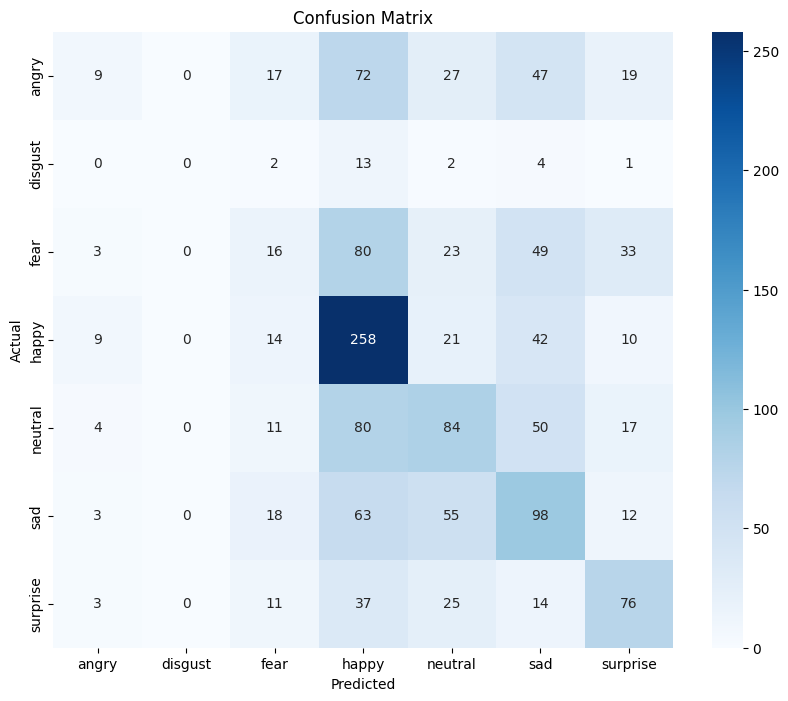

In [15]:
# see confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices, yticklabels=train_data.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

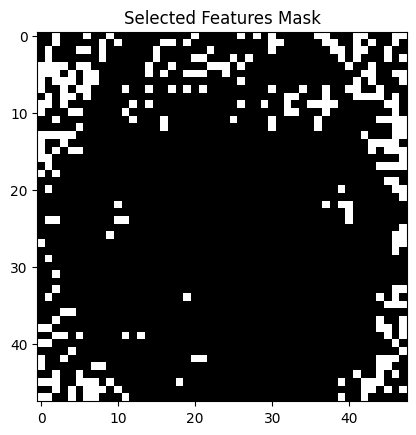

In [9]:
# Create binary mask for selected features
mask = np.zeros(48*48)
mask[selector.selected_indices] = 1
mask = mask.reshape(48, 48)

# Apply mask during preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    preprocessing_function=lambda x: x * mask
)

plt.imshow(mask, cmap='gray')
plt.title('Selected Features Mask')
plt.show()

O Algoritmo 1 deteta corretamente a região da cara como relevante, os contornos/sombras da cara como irrelevantes. Devido à alta variância dos pixeis correspondentes ao fundo da imagem esses pixeis não são filtrados.

Média de tempo de execução ms/step
Sem algoritmo: 91.3 
Com algoritmo1: 78.7

23/23 [==============================] - 0s 19ms/step - loss: 1.5747 - accuracy: 0.3778
Validation Accuracy: 37.78%
23/23 [==============================] - 0s 18ms/step
Confusion Matrix:
[[  9   0  17  72  27  47  19]
 [  0   0   2  13   2   4   1]
 [  3   0  16  80  23  49  33]
 [  9   0  14 258  21  42  10]
 [  4   0  11  80  84  50  17]
 [  3   0  18  63  55  98  12]
 [  3   0  11  37  25  14  76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.05      0.08       191
           1       0.00      0.00      0.00        22
           2       0.18      0.08      0.11       204
           3       0.43      0.73      0.54       354
           4       0.35      0.34      0.35       246
           5       0.32      0.39      0.35       249
           6       0.45      0.46      0.46       166

    accuracy                           0.38      1432
   macro avg       0.29      0.29      0.27      1432
weighted avg       0.34     

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

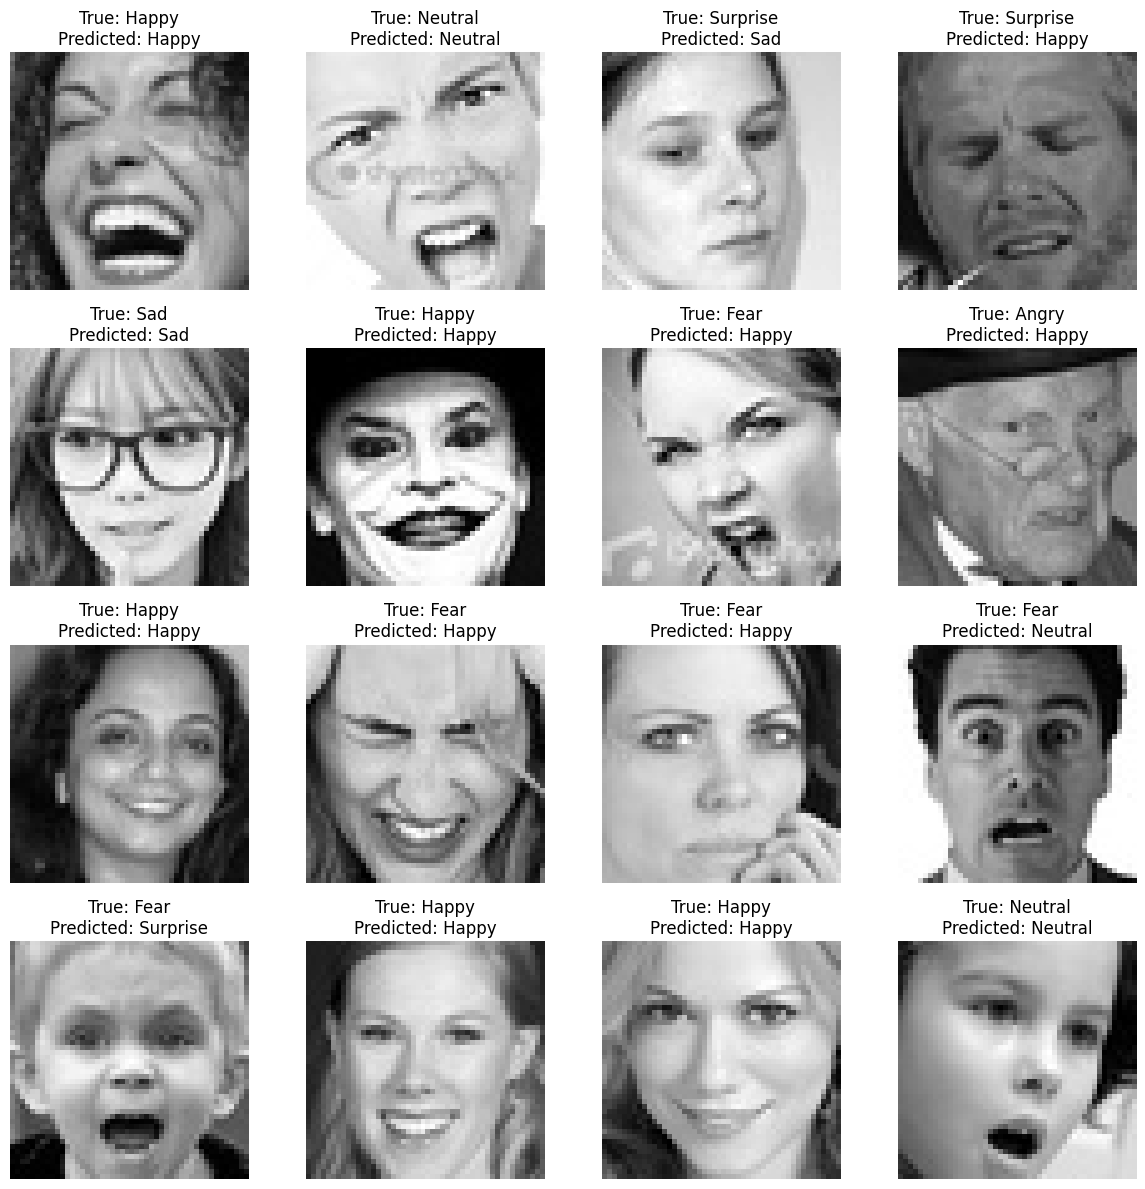

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 43, 43, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 5184)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

# 4. Evaluate model
eval_results = model.evaluate(val_gen)
print(f"Validation Accuracy: {eval_results[1] * 100:.2f}%")

# 5. Make predictions
y_pred = model.predict(val_gen)
y_true = np.argmax(y_val_full, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# 6. Generate metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# 7. Visualize predictions
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(y_true))
    ax.imshow(X_val_full[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred[idx]]}")
plt.tight_layout()
plt.show()

# 8. Save model
model.save('emotion_model.h5')

# 9. Load model
loaded_model = models.load_model('emotion_model.h5')
loaded_model.summary()

# 10. Make predictions with loaded model
y_pred = loaded_model.predict(val_gen)